In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
%matplotlib inline
from sklearn.model_selection import train_test_split,ShuffleSplit
sys.path.append('/localscratch/data/project_one/update/')
import util
%load_ext autoreload
%autoreload 2

In [31]:
_input = pd.read_pickle('/localscratch/data/project_one/data/chart/stocks/ALV.DE.p')
_classification = pd.read_pickle('/localscratch/data/project_one/data/classification/stocks/ALV.DE.p')


common_dates =util.find_common_notnull_dates(_input,_classification)

_input  = _input.loc[_input['Date'].isin(common_dates)]
Xfull  = _input.loc[:,_input.columns.isin(['Date','Close']) == False].values

_classification = _classification.loc[_classification['Date'].isin(common_dates)]
Yfull = _classification.loc[:,_classification.columns.isin(['Date']) == False].values*1.0



Xfull -= np.mean(Xfull,axis=0)
Xfull /= np.std(Xfull,axis=0)


print Xfull.shape,Yfull.shape

(4337, 50) (4337, 6)


(3903, 50) (434, 50) (3903, 6) (434, 6)
-0.74817673439


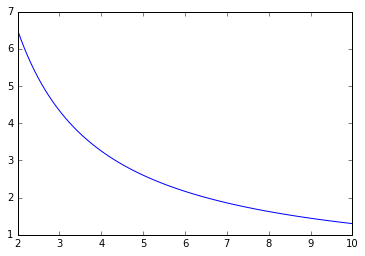

In [32]:
xtrain,xtest,ytrain,ytest = train_test_split(Xfull,Yfull,test_size=0.1)
print xtrain.shape,xtest.shape,ytrain.shape,ytest.shape
print xtrain[0,0]

alphas = np.linspace(2,10,100)

plt.plot(alphas,xtrain.shape[0]/(alphas*(xtrain.shape[1] * ytrain.shape[1])))
plt.show()

In [33]:
n_nodes_hl1=200
n_nodes_hl2=150
n_nodes_hl3=100
n_nodes_hl4=100
n_nodes_hl5=100

lr = 1e-6
n_classes=6

x = tf.placeholder('float',[None,xtrain.shape[1]])
y = tf.placeholder('float')

def nn_model(data):
    h1_layer = {'weights':tf.Variable(tf.random_normal([xtrain.shape[1],n_nodes_hl1])),
                'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}
    
    h2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1,n_nodes_hl2])),
                'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}
    
    h3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2,n_nodes_hl3])),
                'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}
    
    #h4_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3,n_nodes_hl4])),
    #            'biases':tf.Variable(tf.random_normal([n_nodes_hl4]))}
    
    #h5_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl4,n_nodes_hl5])),
     #           'biases':tf.Variable(tf.random_normal([n_nodes_hl5]))}
    
    out_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3,n_classes])),
                'biases':tf.Variable(tf.random_normal([n_classes]))}
    
    l1 = tf.add(tf.matmul(data,h1_layer['weights']), h1_layer['biases'])
    l1 = tf.nn.sigmoid(l1)
    
    l2 = tf.add(tf.matmul(l1,h2_layer['weights']), h2_layer['biases'])
    l2 = tf.nn.sigmoid(l2)
    
    l3 = tf.add(tf.matmul(l2,h3_layer['weights']), h3_layer['biases'])
    l3 = tf.nn.sigmoid(l3)
    
#    l4 = tf.add(tf.matmul(l3,h4_layer['weights']), h3_layer['biases'])
 #   l4 = tf.nn.sigmoid(l4)
    
  #  l5= tf.add(tf.matmul(l4,h5_layer['weights']), h4_layer['biases'])
  #  l5= tf.nn.sigmoid(l5)
    
    
    output = tf.matmul(l3,out_layer['weights']) + out_layer['biases']
    
    return output

def train_nn(x):
    prediction = nn_model(x)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
    
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    hm_epochs = 3000
    
    acc = np.zeros([hm_epochs/10,3])
    k =0 
    print xtrain.shape,ytrain.shape
    #training
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(hm_epochs):
        
            c= sess.run([optimizer,cost],feed_dict={x:xtrain,y:ytrain})

            if np.mod(epoch,10) == 0:    
                acc[k,0] = epoch
                acc[k,1] = c[1]
                correct = tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
                accuracy =tf.cast(correct,'float')
                acc[k,2] = np.mean(accuracy.eval({x:xtest,y:ytest}))
                k+=1
            if np.mod(epoch,500) == 0:
                print'Epoch',epoch,'completed out of',hm_epochs,'loss:',c[1]
                #print tf.cast(y,'float')
                correct = tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
           
                accuracy =tf.cast(correct,'float')
                print "accuracy: ", np.mean(accuracy.eval({x:xtest,y:ytest}))
        return acc

In [34]:
acc = train_nn(x)

(3903, 50) (3903, 6)
Epoch 0 completed out of 3000 loss: 7.06454
accuracy:  0.135945
Epoch 500 completed out of 3000 loss: 0.634006
accuracy:  0.391705
Epoch 1000 completed out of 3000 loss: 0.224262
accuracy:  0.417051
Epoch 1500 completed out of 3000 loss: 0.0800059
accuracy:  0.421659
Epoch 2000 completed out of 3000 loss: 0.0337461
accuracy:  0.40553
Epoch 2500 completed out of 3000 loss: 0.01679
accuracy:  0.423963


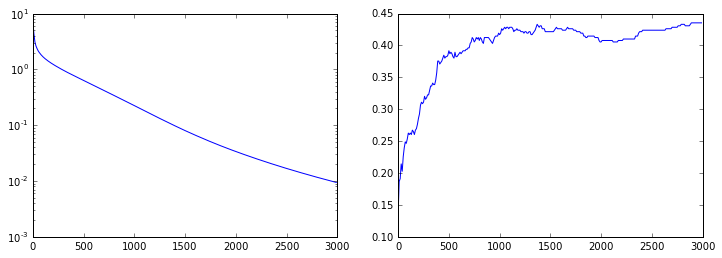

In [36]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].semilogy(acc[:,0],acc[:,1])

ax[1].plot(acc[:,0],acc[:,2])
plt.show()